# Telco_Churn_Project:

# Overview:

# Goal: 
* 
* 

# Imports

In [1]:
# Standard ds imports:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

# Statistics
from scipy import stats

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import \
accuracy_score,\
recall_score,\
precision_score,\
confusion_matrix,\
classification_report

import warnings
warnings.filterwarnings("ignore")

# Custom Modules
import os
import env

In [2]:
target = 'churn'

## Planning
**Plan** --> Acquire --> Prepare --> Explore --> Model --> Deliver

* 

## Acquire
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

In [3]:
def get_connection_url(db, user=env.user, host=env.host, password=env.password):
    """
    This function will:
    - take username, pswd, host credentials from imported env module
    - output a formatted connection_url to access mySQL db
    """
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [4]:
def new_telco_data():
    '''
    This function reads the telco data from the Codeup db into a df.
    '''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection_url('telco_churn'))
    
    return df

In [5]:
def get_telco_data():
    '''
    This function reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df

In [6]:
df = get_telco_data()

In [7]:
df.shape

(7043, 24)

In [8]:
df.payment_type.value_counts()

payment_type
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

## Prepare
Plan --> Acquire --> **Prepare** --> Explore --> Model --> Deliver

### STEP 1: Summarize
<b>a</b>. understand your data

<b>b</b>. visualize your variables (univariate only)

#### Step 1a. Understand Your Data:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_support 

#### Step 1b. Visualize Your Data (univariate)

In [10]:
#find only numeric columns
num_col = df.select_dtypes(include='number').columns
num_col

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'senior_citizen', 'tenure', 'monthly_charges'],
      dtype='object')

payment_type_id


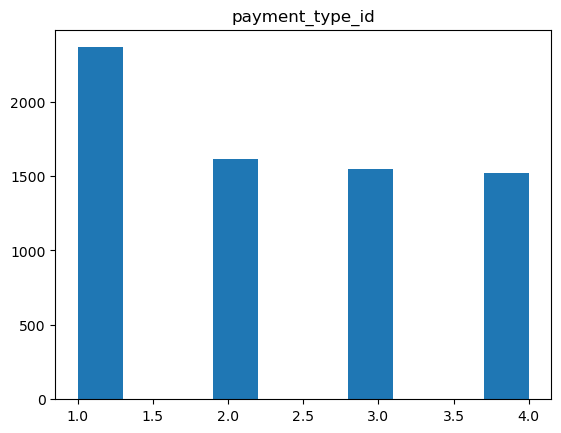

internet_service_type_id


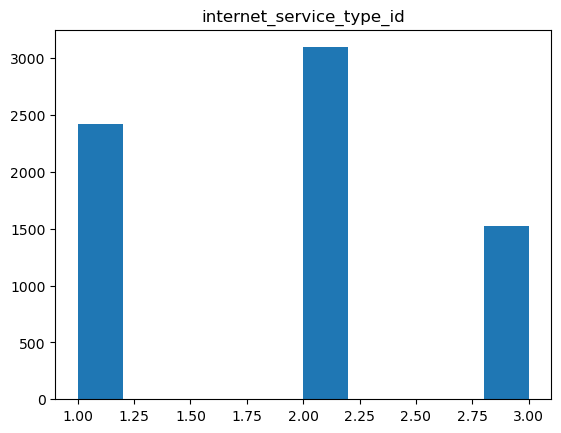

contract_type_id


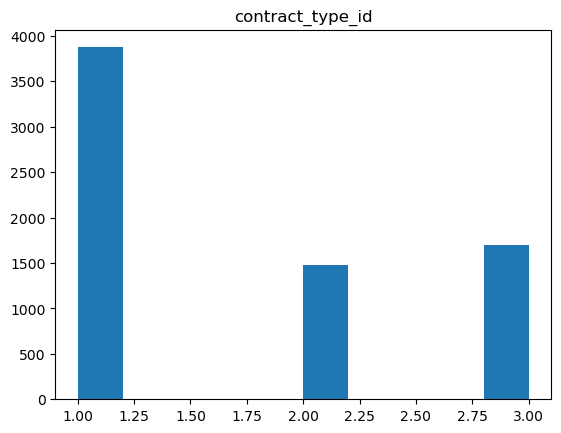

senior_citizen


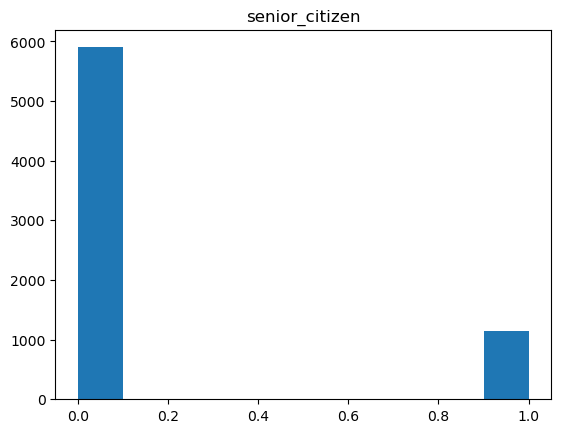

tenure


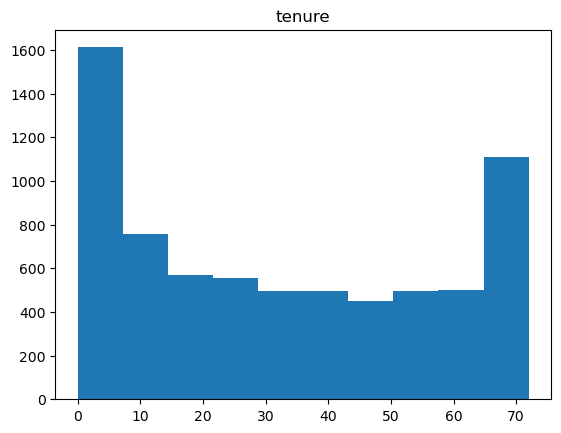

monthly_charges


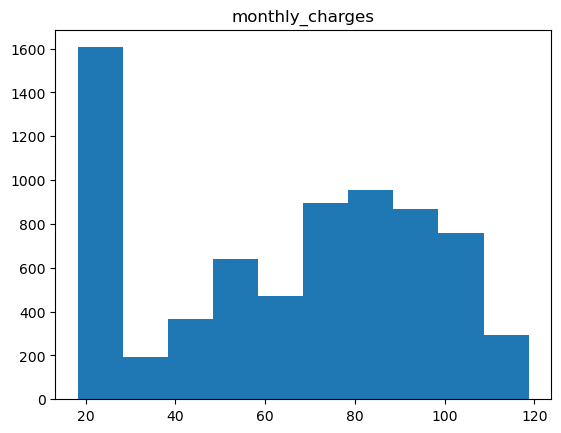

In [11]:
#plot distributions of numeric columns
for col in num_col:
    print(col)
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [12]:
#find only string columns
str_col = df.select_dtypes(exclude='number').columns
str_col

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type'],
      dtype='object')

In [13]:
df.isnull().sum()

payment_type_id                0
internet_service_type_id       0
contract_type_id               0
customer_id                    0
gender                         0
senior_citizen                 0
partner                        0
dependents                     0
tenure                         0
phone_service                  0
multiple_lines                 0
online_security                0
online_backup                  0
device_protection              0
tech_support                   0
streaming_tv                   0
streaming_movies               0
paperless_billing              0
monthly_charges                0
total_charges                  0
churn                          0
contract_type                  0
internet_service_type       1526
payment_type                   0
dtype: int64

In [14]:
df.internet_service_type.value_counts(dropna=False)

internet_service_type
Fiber optic    3096
DSL            2421
NaN            1526
Name: count, dtype: int64

gender
gender
Male      3555
Female    3488
Name: count, dtype: int64
gender
Male      0.504756
Female    0.495244
Name: proportion, dtype: float64


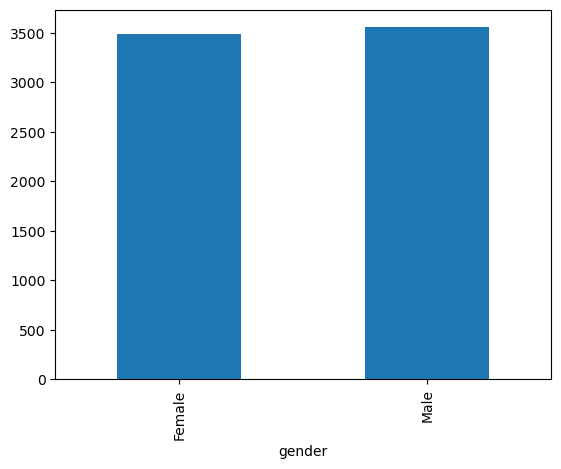


partner
partner
No     3641
Yes    3402
Name: count, dtype: int64
partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64


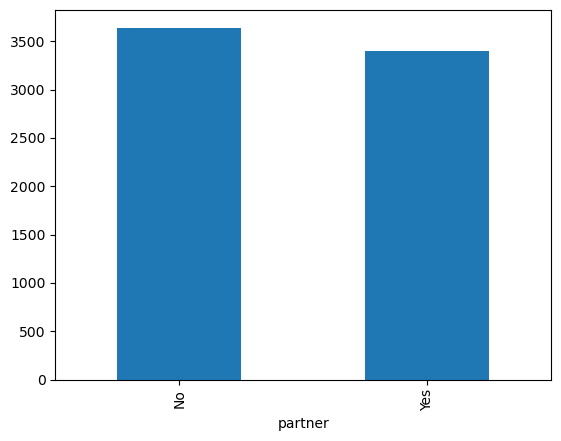


dependents
dependents
No     4933
Yes    2110
Name: count, dtype: int64
dependents
No     0.700412
Yes    0.299588
Name: proportion, dtype: float64


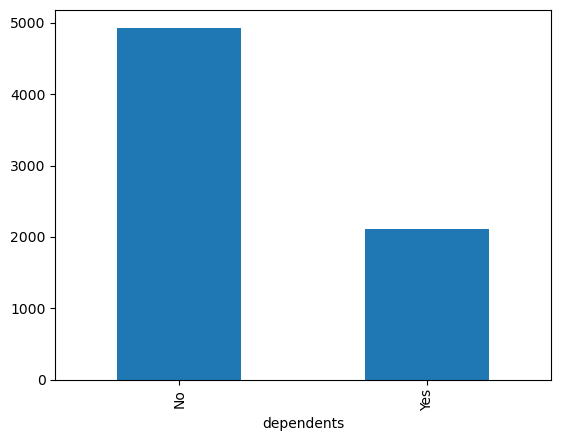


phone_service
phone_service
Yes    6361
No      682
Name: count, dtype: int64
phone_service
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64


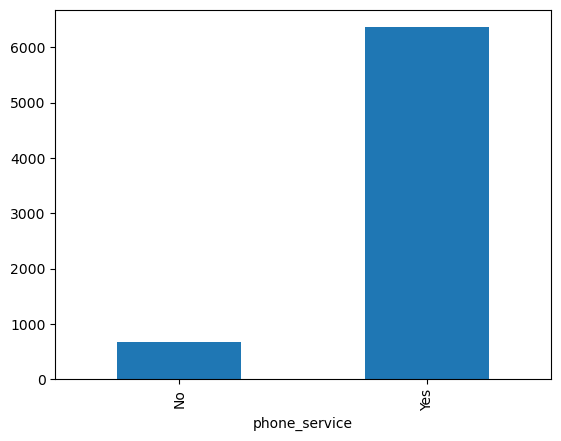


multiple_lines
multiple_lines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
multiple_lines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64


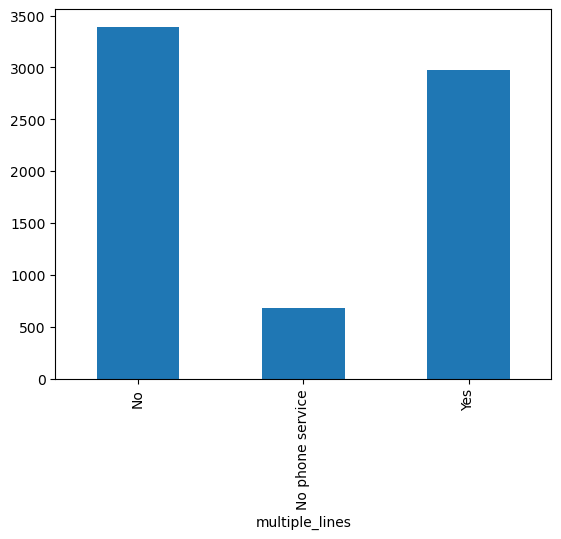


online_security
online_security
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
online_security
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: proportion, dtype: float64


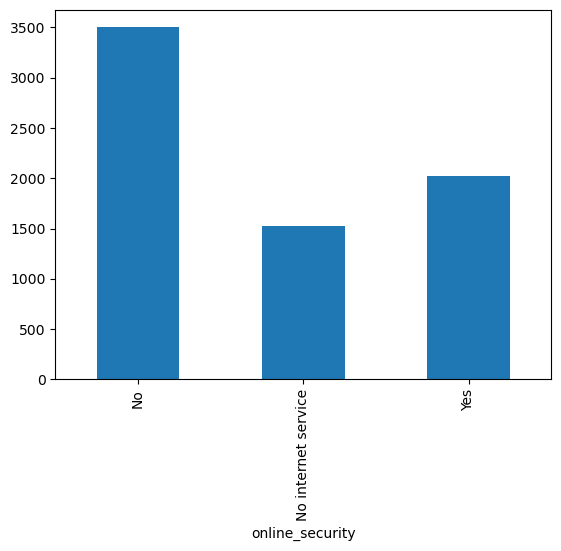


online_backup
online_backup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64
online_backup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: proportion, dtype: float64


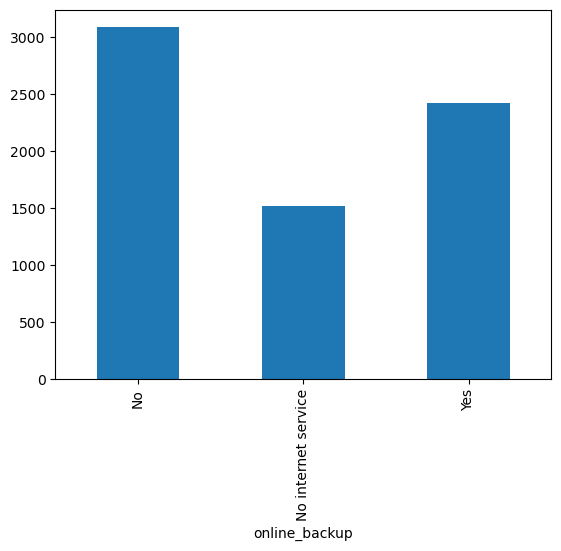


device_protection
device_protection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64
device_protection
No                     0.439443
Yes                    0.343888
No internet service    0.216669
Name: proportion, dtype: float64


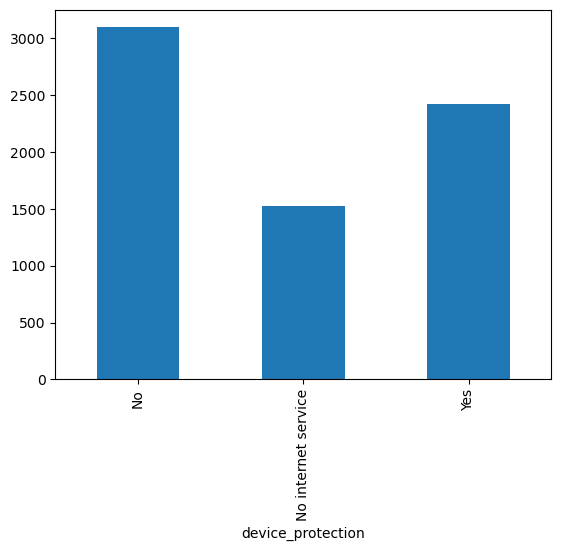


tech_support
tech_support
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64
tech_support
No                     0.493114
Yes                    0.290217
No internet service    0.216669
Name: proportion, dtype: float64


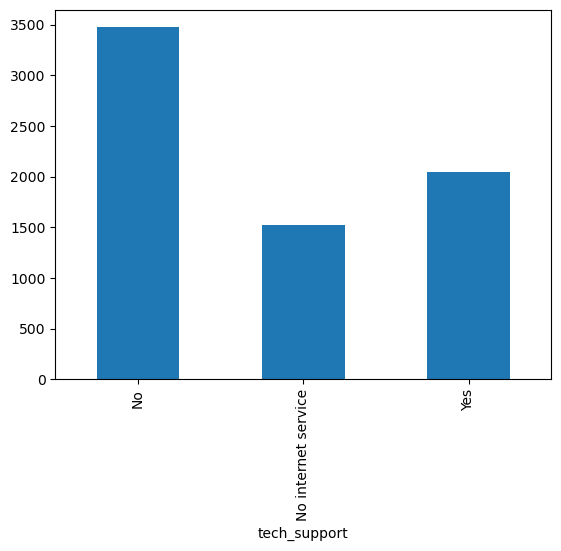


streaming_tv
streaming_tv
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64
streaming_tv
No                     0.398978
Yes                    0.384353
No internet service    0.216669
Name: proportion, dtype: float64


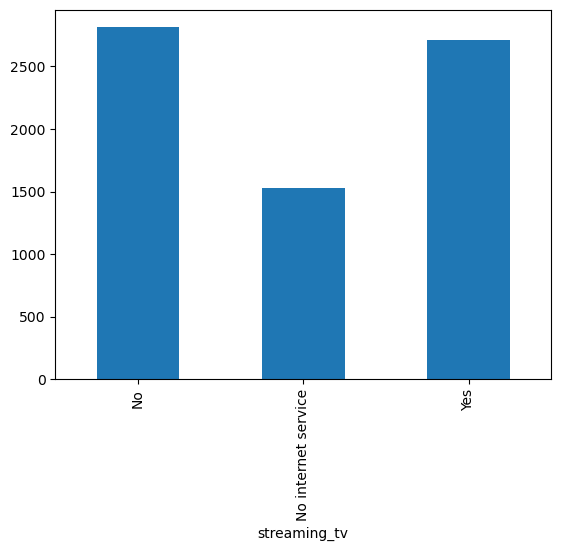


streaming_movies
streaming_movies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64
streaming_movies
No                     0.395428
Yes                    0.387903
No internet service    0.216669
Name: proportion, dtype: float64


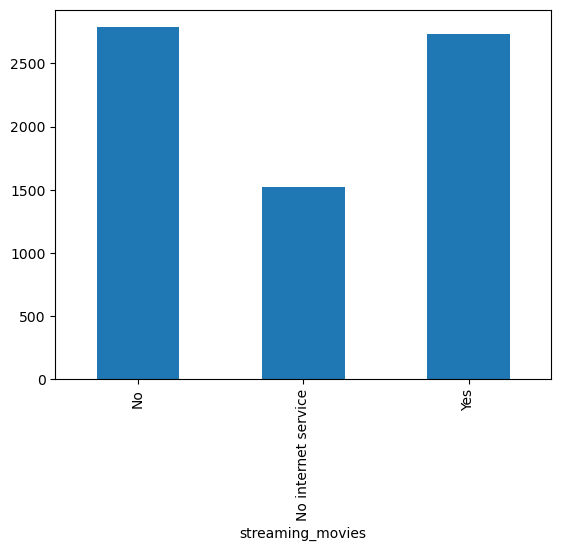


paperless_billing
paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64
paperless_billing
Yes    0.592219
No     0.407781
Name: proportion, dtype: float64


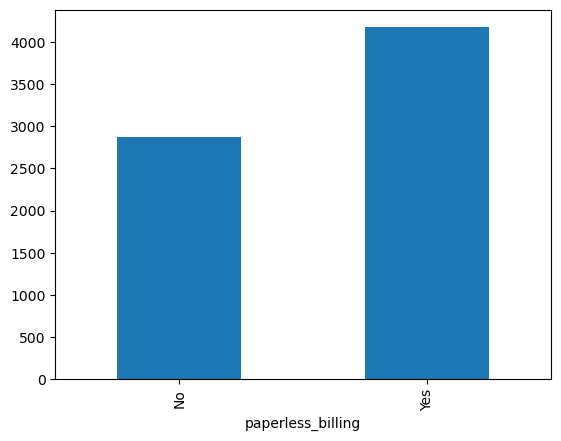


total_charges
total_charges
           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
2387.75     1
6302.8      1
2058.5      1
829.55      1
3707.6      1
Name: count, Length: 6531, dtype: int64
total_charges
           0.001562
20.2       0.001562
19.75      0.001278
19.9       0.001136
20.05      0.001136
             ...   
2387.75    0.000142
6302.8     0.000142
2058.5     0.000142
829.55     0.000142
3707.6     0.000142
Name: proportion, Length: 6531, dtype: float64


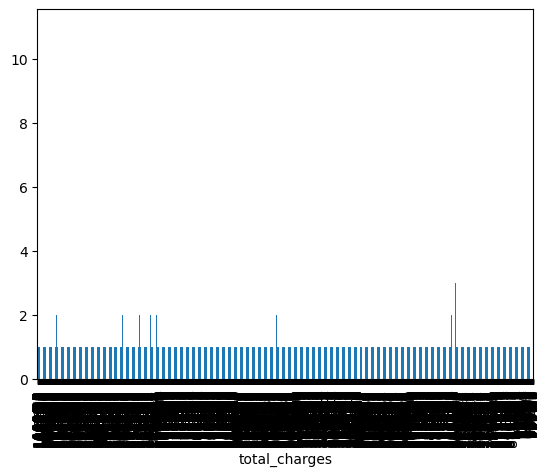


churn
churn
No     5174
Yes    1869
Name: count, dtype: int64
churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


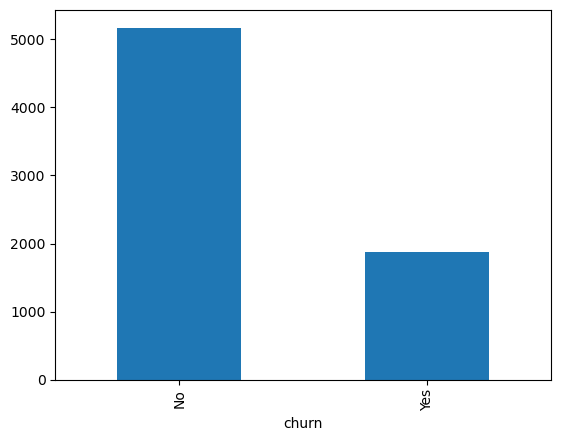


contract_type
contract_type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
contract_type
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: proportion, dtype: float64


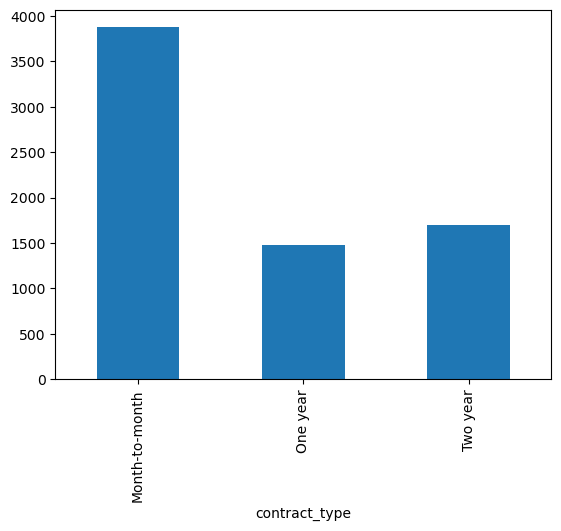


internet_service_type
internet_service_type
Fiber optic    3096
DSL            2421
Name: count, dtype: int64
internet_service_type
Fiber optic    0.561175
DSL            0.438825
Name: proportion, dtype: float64


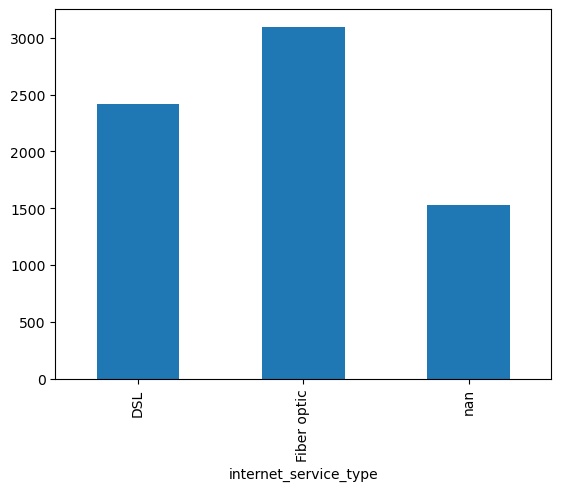


payment_type
payment_type
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64
payment_type
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: proportion, dtype: float64


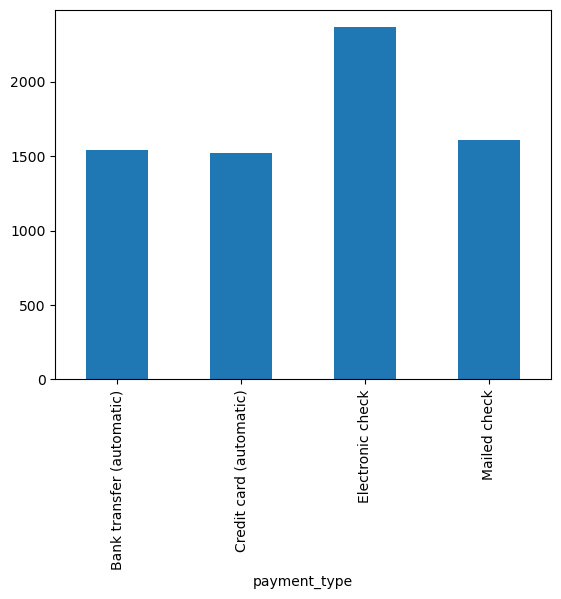

In [15]:
#plot distributions of string columns

for col in str_col[1:]:
    print(col)
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True)) #percentage
    df[col].value_counts(dropna=False).sort_index().plot.bar()
    plt.show()
    print()


## Prepare- STEP 2: Clean the data

<b>a</b>. take care of duplicates **DROP payment_type_id, internet_service_type_id, contract_type_id**

<b>b</b>. verify datatypes **total_charges will need to be converted to float. Will need to encode any string features that we would like to inlcude.**

<b>c</b>. handle nulls **internet_service_type Is the only column with nulls. It is equivalent to internet_service_type_id, so we will just impute string "No Internet Service".**

<b>d</b>. consider outliers **No outliers.**

<b>e</b>. for modeling: make all columns numeric **Done**

### Step 2a. Duplicate Data

In [16]:
#look at data
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [17]:
df.customer_id.duplicated().sum()

0

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_support 

In [19]:
#view counts across both
pd.crosstab(df.payment_type_id, df.payment_type)

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
payment_type_id,,,,
1,0,0,2365,0
2,0,0,0,1612
3,1544,0,0,0
4,0,1522,0,0


In [20]:
pd.crosstab(df.contract_type_id , df.contract_type)

contract_type,Month-to-month,One year,Two year
contract_type_id,,,
1,3875,0,0
2,0,1473,0
3,0,0,1695


In [21]:
pd.crosstab(df.internet_service_type_id , df.internet_service_type)

internet_service_type,DSL,Fiber optic
internet_service_type_id,,
1,2421,0
2,0,3096


### Step 2b. Verify Datatypes

In [22]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [23]:
df.isnull().sum() [df.isnull().sum() > 0]

internet_service_type    1526
dtype: int64

### Step 2d. Outliers

In [24]:
# Looking at our initial hist plots there doesn't seem to be any outliers. However, we haven't transformed total_charges yet, so we will keep an eye on it after.

### Step 2e. For Modeling: Make all columns numeric (encode)

In [25]:
def split_function(df, target_varible):
    train, test = train_test_split(df,
                                   random_state=666,
                                   test_size=.20,
                                   stratify= df['churn'])
    
    train, validate = train_test_split(train,
                                   random_state=666,
                                   test_size=.25,
                                   stratify= train['churn'])
    return train, validate, test

In [26]:
def prep_telco(df):
    '''
    This function will drop any duplicate observations, split into train, val, test using split_function, impute 'internet_service_type' with "No Internet Service", drop ['contract_type_id', 'payment_type_id', 'internet_service_type_id'], create a new column with payment_type organized into either "Manual" or "Automatic", then drop payment_type, create dummy vars from all categorical variables, and change dtype of total_charges to float. 
    '''
    
    # change dtype of total_charges to float
    df['total_charges'] = df.total_charges.str.replace(' ', '0').astype(float)
    
    #drop out any redundant, excessively empty, or bad columns
    df = df.drop_duplicates()
    df = df.drop(columns=['contract_type_id', 'payment_type_id', 'internet_service_type_id', 'customer_id'])
    
    # Organize payment_type into Auto and Manual
    df['mapped_payment_type'] = df['payment_type'].apply(lambda x: 'Manual' if x in ['Electronic check', 'Mailed check'] else 'Automatic')
    # Drop payment_type
    df = df.drop(columns=['payment_type'])
    
    # split data into train, validate, test
    train, validate, test = split_function(df, target)
    
    # impute train['internet_service_type'] with 'No Internet Service'
    train['internet_service_type'] = train['internet_service_type'].fillna(value='No Internet Service')
    # impute train['internet_service_type'] with 'No Internet Service'
    validate['internet_service_type'] = validate['internet_service_type'].fillna(value='No Internet Service')
    # impute train['internet_service_type'] with 'No Internet Service'
    test['internet_service_type'] = test['internet_service_type'].fillna(value='No Internet Service')
    
    
    # Manually encode binary categorical variables for train
    train['gender_encoded'] = train.gender.map({'Female': 1, 'Male':0})
    train['partner_encoded'] = train.partner.map({'Yes':1, 'No':0})
    train['dependents_encoded'] = train.dependents.map({'Yes':1, 'No':0})
    train['phone_service_encoded'] = train.phone_service.map({'Yes':1, 'No':0})
    train['paperless_billing_encoded'] = train.paperless_billing.map({'Yes':1, 'No':0})
    train['churn_encoded'] = train.churn.map({'Yes':1, 'No':0})
    
    # Manually encode binary categorical variables for validate
    validate['gender_encoded'] = validate.gender.map({'Female': 1, 'Male':0})
    validate['partner_encoded'] = validate.partner.map({'Yes':1, 'No':0})
    validate['dependents_encoded'] = validate.dependents.map({'Yes':1, 'No':0})
    validate['phone_service_encoded'] = validate.phone_service.map({'Yes':1, 'No':0})
    validate['paperless_billing_encoded'] = validate.paperless_billing.map({'Yes':1, 'No':0})
    validate['churn_encoded'] = validate.churn.map({'Yes':1, 'No':0})
    
    # Manually encode binary categorical variables for test
    test['gender_encoded'] = test.gender.map({'Female': 1, 'Male':0})
    test['partner_encoded'] = test.partner.map({'Yes':1, 'No':0})
    test['dependents_encoded'] = test.dependents.map({'Yes':1, 'No':0})
    test['phone_service_encoded'] = test.phone_service.map({'Yes':1, 'No':0})
    test['paperless_billing_encoded'] = test.paperless_billing.map({'Yes':1, 'No':0})
    test['churn_encoded'] = test.churn.map({'Yes':1, 'No':0})
    
    
    # use pd.get_dummies to encode nonbinary categorical varibales
    dummy_train = pd.get_dummies(train[['multiple_lines',
                                     'online_security',
                                     'online_backup',
                                     'device_protection', 
                                     'tech_support',
                                     'streaming_tv',
                                     'streaming_movies', 
                                     'contract_type', 
                                     'internet_service_type',
                                     'mapped_payment_type']],
                                  drop_first=True,
                                  dtype=int)
    
    # use pd.get_dummies to encode nonbinary categorical varibales
    dummy_validate = pd.get_dummies(validate[['multiple_lines',
                                     'online_security',
                                     'online_backup',
                                     'device_protection', 
                                     'tech_support',
                                     'streaming_tv',
                                     'streaming_movies', 
                                     'contract_type', 
                                     'internet_service_type',
                                     'mapped_payment_type']],
                                  drop_first=True,
                                  dtype=int)
    
    # use pd.get_dummies to encode nonbinary categorical varibales
    dummy_test = pd.get_dummies(test[['multiple_lines',
                                     'online_security',
                                     'online_backup',
                                     'device_protection', 
                                     'tech_support',
                                     'streaming_tv',
                                     'streaming_movies', 
                                     'contract_type', 
                                     'internet_service_type',
                                     'mapped_payment_type']],
                                  drop_first=True,
                                  dtype=int)

    train = pd.concat([train, dummy_train], axis=1)
    validate = pd.concat([validate, dummy_validate], axis=1)
    test = pd.concat([test, dummy_test], axis=1)
    
    return train, validate, test

In [27]:
train, validate, test = prep_telco(df)

In [28]:
train.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'internet_service_type', 'mapped_payment_type',
       'gender_encoded', 'partner_encoded', 'dependents_encoded',
       'phone_service_encoded', 'paperless_billing_encoded', 'churn_encoded',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'contrac

## Explore
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

 - What can we say about the data now that we have it in proper working condition?
  - Steps in this process:

1. Univariate Exploration
    - visualizations (distributive)
2. Bivariate Exploration
    - visualizations (comparative)
    - statistical testing
3. Multivariate Exploration
    - visualizations(comparative)
    - statistical testing
    - clues for feature engineering

> **EXPLORE ONLY TRAIN DATA**

### Initial Questions:
 - What features may lead to customer churn?
    - Does monthly_charges impact customer churn rate?
    - Which add-ons, if any are least associated with customer churn? Most?
    - What is the distribution of features for customers with the longest tenure?
    - What is the distribution of features for churned customers with the shortest tenure?
    - Does payment_type impact customer churn?

Step One: Univariate examination

Let's get some eyes on the spread of our features before we press forward with relationships

In [117]:
features1 = ['monthly_charges',
       'tech_support_No internet service', 'tech_support_Yes',
       'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'mapped_payment_type_Manual']

In [118]:
# Separate into X and y:
X_train, y_train = \
train[features1], \
train[target]

X_validate, y_validate = \
validate[features1], \
validate[target]

X_test, y_test = \
test[features1], \
test[target]

In [30]:
explore_columns = X_train.drop(columns=['gender_encoded', 'partner_encoded',
       'dependents_encoded', 'phone_service_encoded',
       'paperless_billing_encoded', 'multiple_lines_No phone service',
       'multiple_lines_Yes', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No internet service',
       'online_backup_Yes', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'streaming_tv_No internet service',
       'streaming_tv_Yes', 'streaming_movies_No internet service',
       'streaming_movies_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service', 'mapped_payment_type_Manual'
       ]).columns.to_list()

In [119]:
X_train.columns

Index(['monthly_charges', 'tech_support_No internet service',
       'tech_support_Yes', 'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'mapped_payment_type_Manual'],
      dtype='object')

In [120]:
# separating our numeric and categorical columns:
# initialize two empty lists for each type:
cat_cols, num_cols = [], []
# set up a for loop to build those lists out:
# so for every column in explore_columns:
for col in explore_columns:
    # check to see if its an object type,
    # if so toss it in categorical
    if train[col].dtype == 'O':
        cat_cols.append(col)
    # otherwise if its numeric:
    else:
        # check to see if we have more than just a few values:
        # if thats the case, toss it in categorical
        if train[col].nunique() < 10:
            cat_cols.append(col)
        # and otherwise call it continuous by elimination
        else:
            num_cols.append(col)

In [121]:
print(cat_cols,'\n', num_cols)

['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'contract_type', 'internet_service_type', 'mapped_payment_type'] 
 ['tenure', 'monthly_charges', 'total_charges']


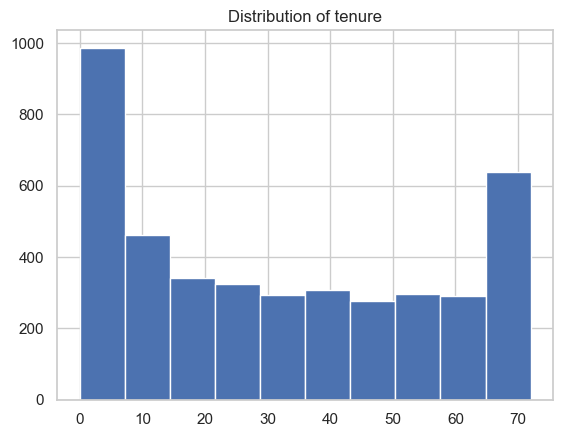

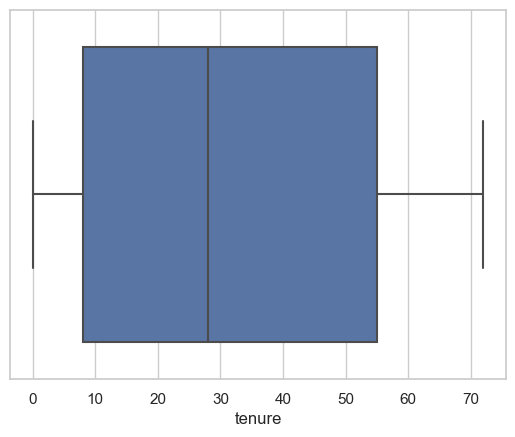

~~~~~~~~~~~~


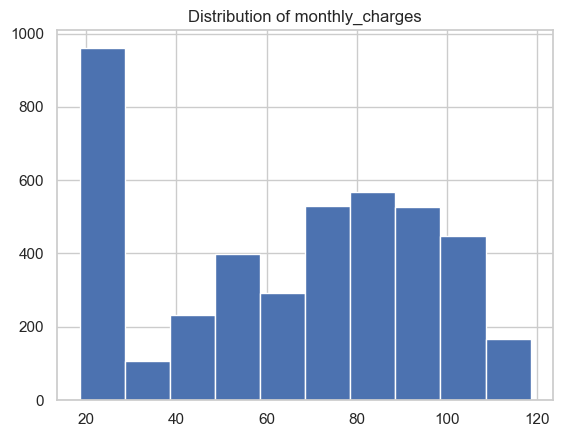

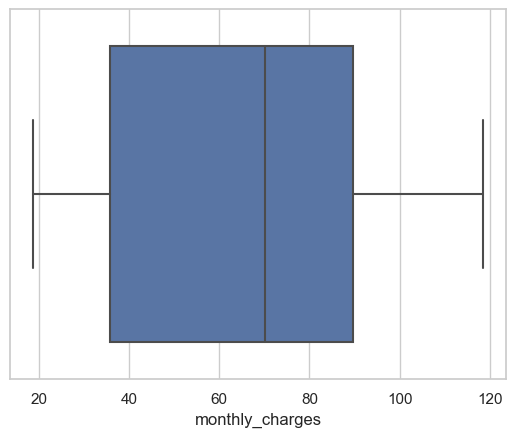

~~~~~~~~~~~~


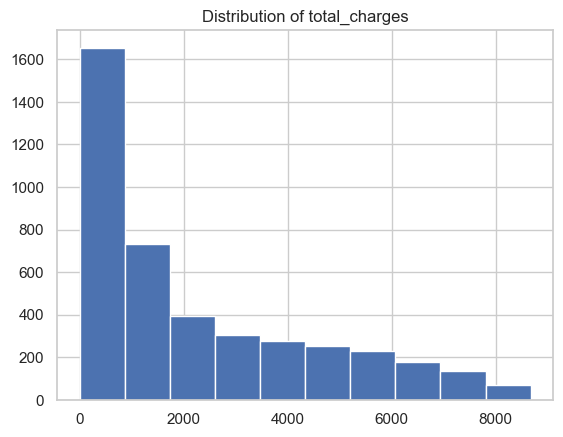

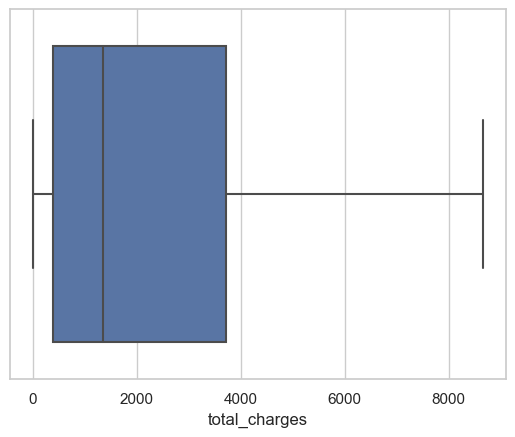

~~~~~~~~~~~~


In [122]:
# for our continuous variables,
# lets get some eyes on outliers and distributions:
for col in num_cols:
    plt.hist(train[col])
    plt.title(f'Distribution of {col}')
    plt.show()
    sns.boxplot(data=train, x=col)
    plt.show()
    print('~~~~~~~~~~~~')

In [123]:
##### Initial Takeaways for continuos variables:
# Under the Central Limit Theorem we can assume a normal sampling distribution
# For tenure: There is a big spike on the left and a smaller, but significant spike on the right.
# Monthly_Charges: Bimodal distribution with a spike on the left and another peak around 85.
# Total_Charges: Dependent on both tenure and monthly charges, it is very highly skewed, right-tailed.

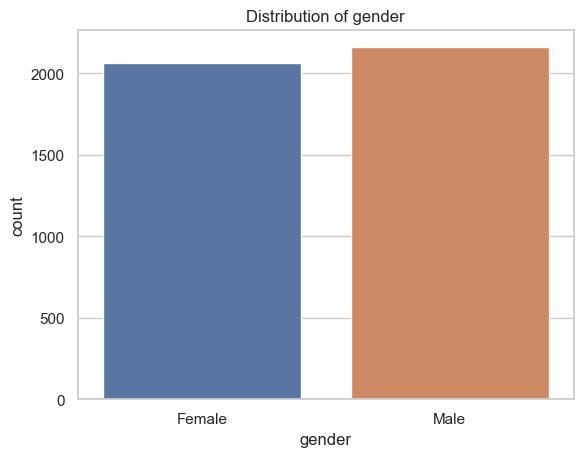

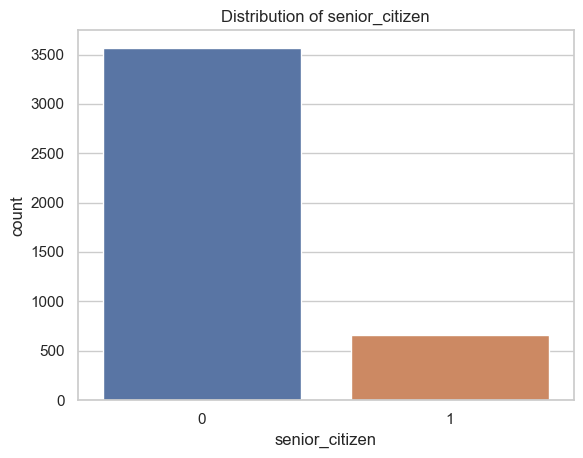

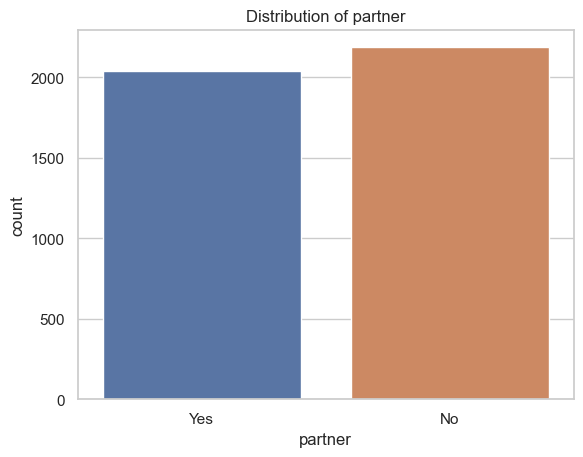

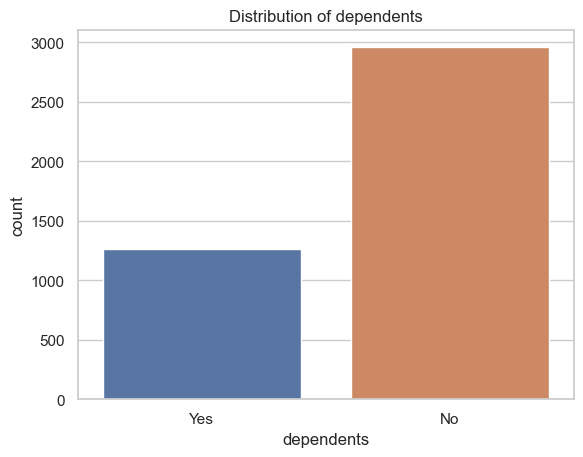

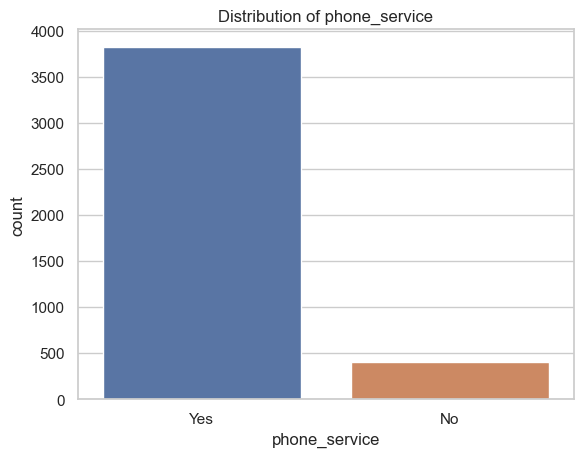

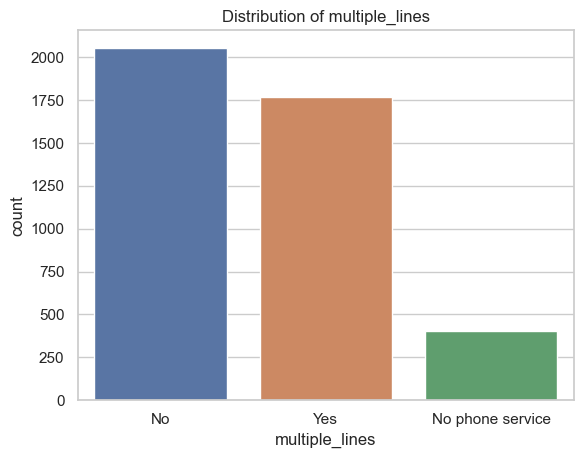

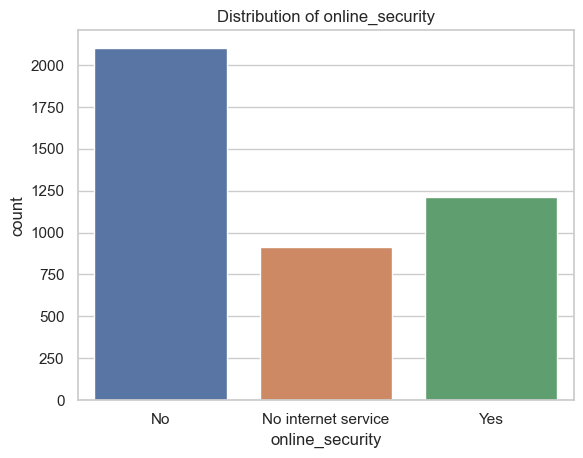

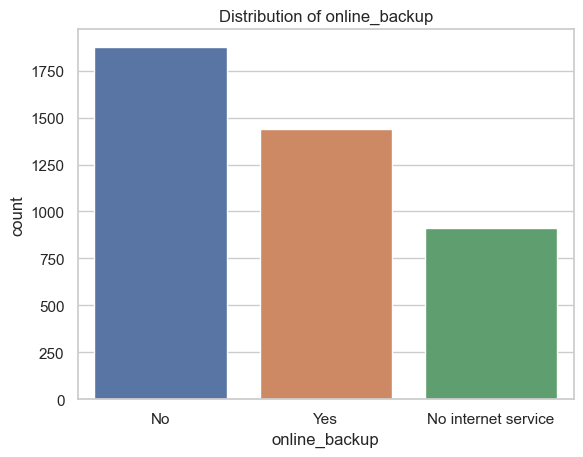

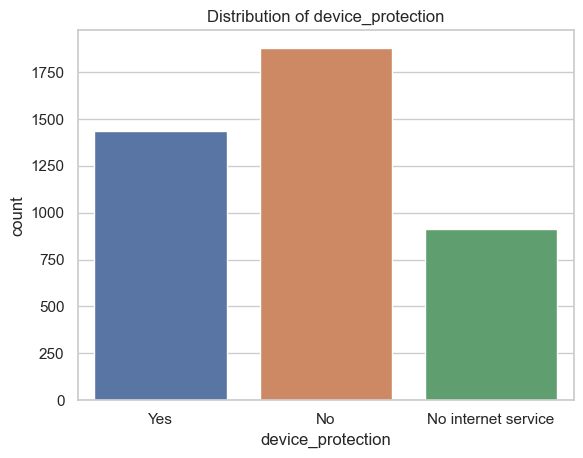

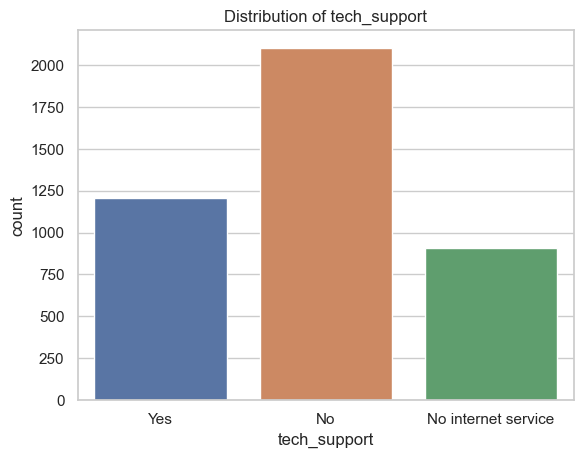

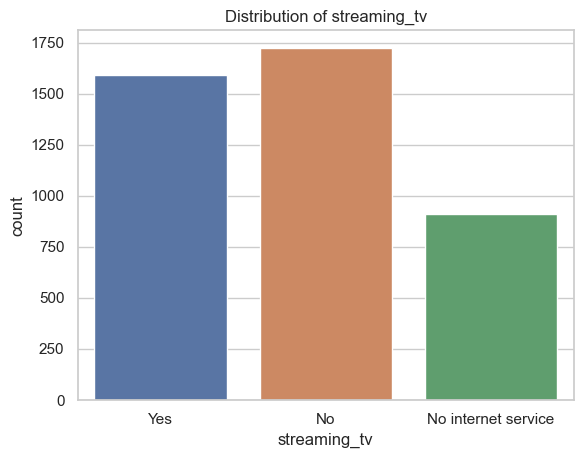

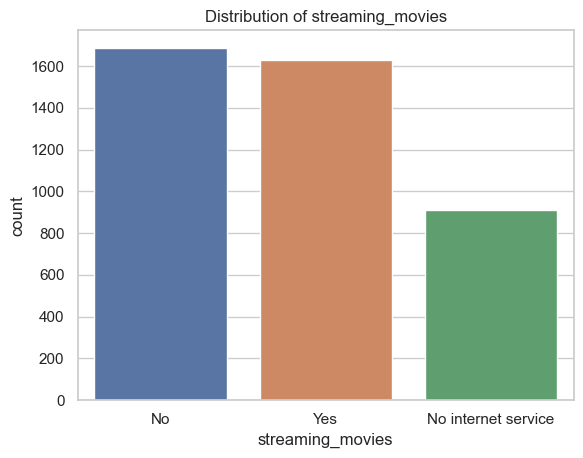

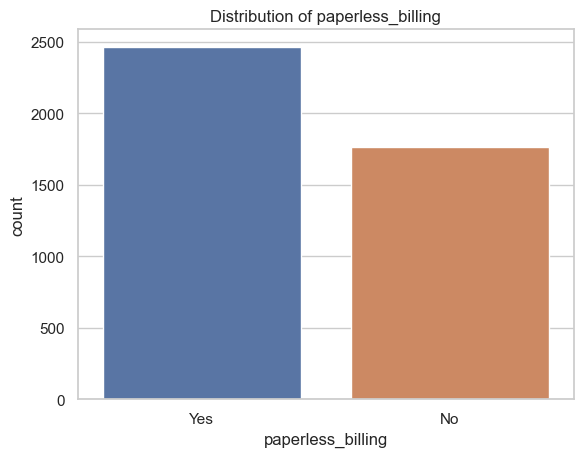

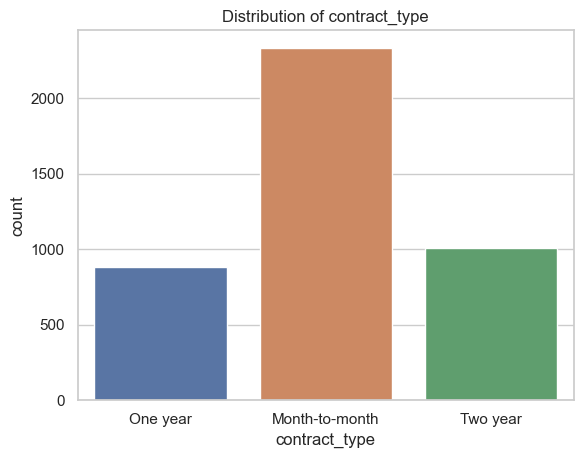

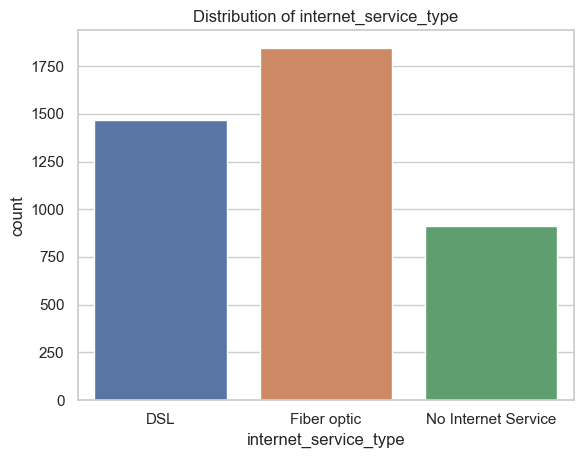

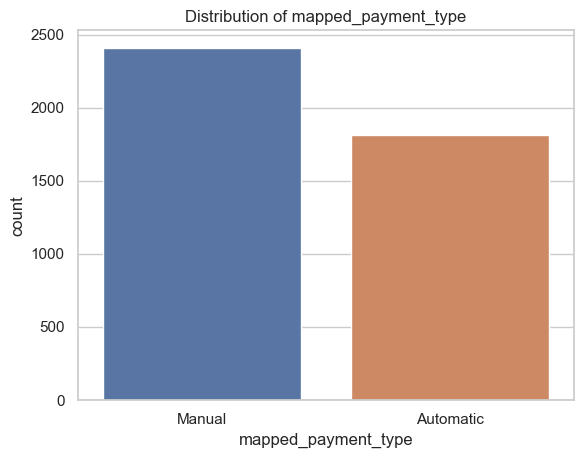

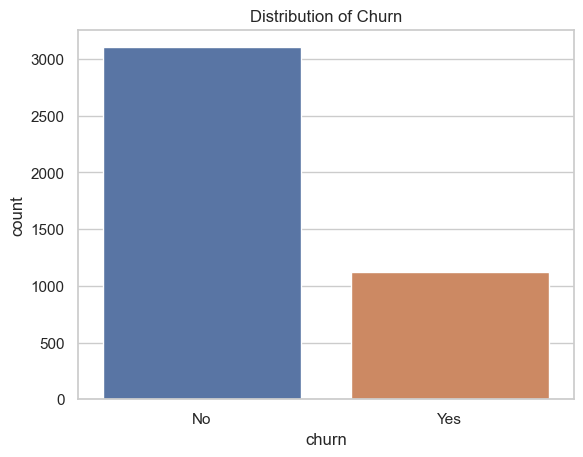

In [124]:
for col in cat_cols:
    sns.countplot(data=train, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()
sns.countplot(data=train, x=target)
plt.title('Distribution of Churn')
plt.show()

In [38]:
# we have categories across the board that have 
# majorities in specific classes: senior_citizen -'0', dependents --'no', phone_service -'yes', contract_type-'month-to-month', churn-'no'
# It appears that the majority of customers are not senior_citizens
# It appears that the majority of customers do not have dependents
# It appears that the majority of customers have phone service
# It appears that about 21.6% of customers do not have internet service
# It appears that the number of customers with month-to-month contracts is approximate to the number of one-year and two-year combined
# Churn rate appears to be about 26.5%

In [39]:
df.internet_service_type.value_counts()

internet_service_type
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

### Bivariate  Analysis:
 - How do these things interact with the target?:
     - Monthly Charges to churn
     - internet service type to churn (dsl vs fiber optic)
     - payment_type (auto vs manual) to churn
### Multivariate Analysis
 - Fiber Optic w/ tech support vs Fiber Optice w/out tech support
 - tenure greater than vs tenure less than??????

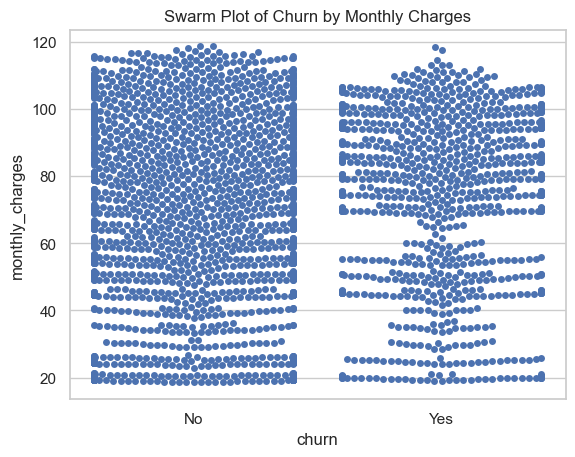

In [98]:

# Lets ask: Is the mean of monthly charges of customers who churn significantly higher than the mean across all customers?
# Visually:
# Create a swarm plot
sns.set(style="whitegrid")  # Set the style of the plot
sns.swarmplot(y='monthly_charges', x=target, data=train)

# Add labels and title
plt.ylabel('monthly_charges')
plt.xlabel(target)
plt.title('Swarm Plot of Churn by Monthly Charges')

# Show the plot
plt.show()


In [41]:
# It looks like there is a higher concentration of churned customers when monthly charges exceed ~70. 
# It looks like there are also 3 separate concentrations of churn around $45, $50, $55; could this be these be where a specific add-ons have higher churn?

In [42]:
### Lets do some stats analysis:
## continuos vs categorical:
## Enough samples under CLT to assume a normal sampling distribution:


In [43]:
#H0: Mean of monthly charges of churned customers <= Mean of monthly charges of all customers.
#Ha: Mean of monthly charges of churned customers > Mean of monthly charges of all customers.
alpha = 0.05

In [44]:
# an array of all observed values of the subgroup
churn_sample = train[train.churn == 'Yes'].monthly_charges

# the population mean
overall_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churn_sample, overall_mean)

print(t, p/2, alpha)

12.86165366693209 1.0358740694591168e-35 0.05


In [45]:
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")


We reject the null hypothesis.


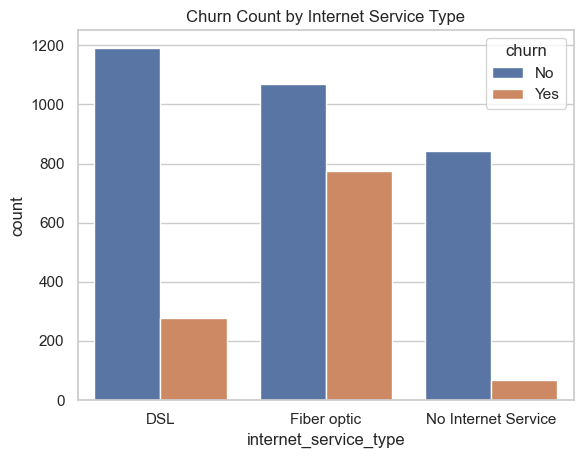

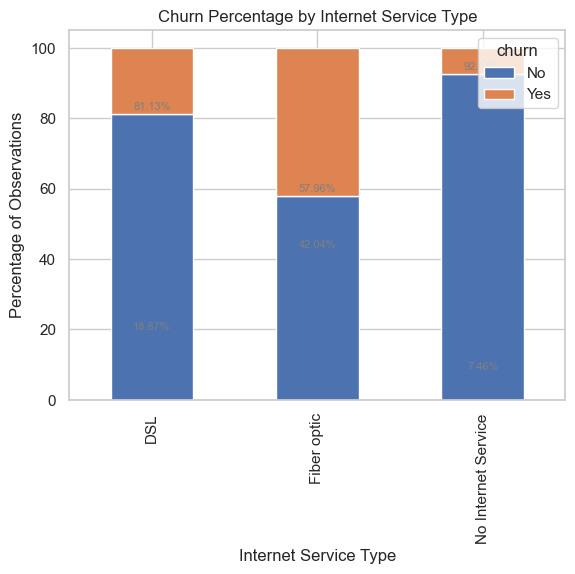

In [46]:
# Lets ask: Is customer churn dependent on internet service type?

#### Vizually:

## Viz 1:
sns.set(style="whitegrid")
data = train
sns.countplot(x="internet_service_type", hue="churn", data=data)
plt.title("Churn Count by Internet Service Type")
plt.show()

## Viz 2:
# Calculate the percentages within each internet_service_type category
percentage_data = data.groupby('internet_service_type')['churn'].value_counts(normalize=True).unstack() * 100

# Set the style
sns.set(style="whitegrid")

# Create the bar plot
ax = percentage_data.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel("Internet Service Type")
plt.ylabel("Percentage of Observations")
plt.title("Churn Percentage by Internet Service Type")

# Annotate with percentage values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='gray', rotation=0, xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.legend(title='churn', loc='upper right')
plt.show()

In [47]:
### It looks like Fiber Optic has the highest rate of churn with 42.04% of customers churning, while customers that have only phone service have the lowest rate of churn (7.46%).
### Question for multivariate: Do Fiber Optic customers that also have tech support churn less than Fiber Optic customers that do not?

In [48]:
### Stats testing
## Categorical to Categorical
## Enough samples to assume normal distribution
# Let use a chi2 test

In [49]:
# H0: Customer churn rate is independent of the internet service type.
# Ha: Customer churn rate has a dependent relationship to internet service type.
alpha = 0.05

observed = pd.crosstab(train['internet_service_type'], train['churn'])
observed

churn,No,Yes
internet_service_type,,
DSL,1191,277
Fiber optic,1070,776
No Internet Service,843,68


In [50]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [51]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')

Observed Values

[[1191  277]
 [1070  776]
 [ 843   68]]
---
Expected Values

[[1078  389]
 [1356  489]
 [ 669  241]]
---

chi^2 = 441.8018
p     = 0.0000


In [52]:
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between internet_service_type and the churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between internet_service_type and churn.')

p-value: 1.1586538084825805e-96
We reject the null hypothesis.
There exists some relationship between internet_service_type and the churn.


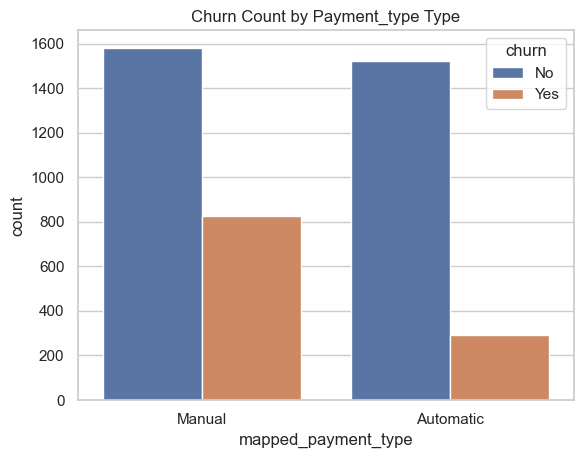

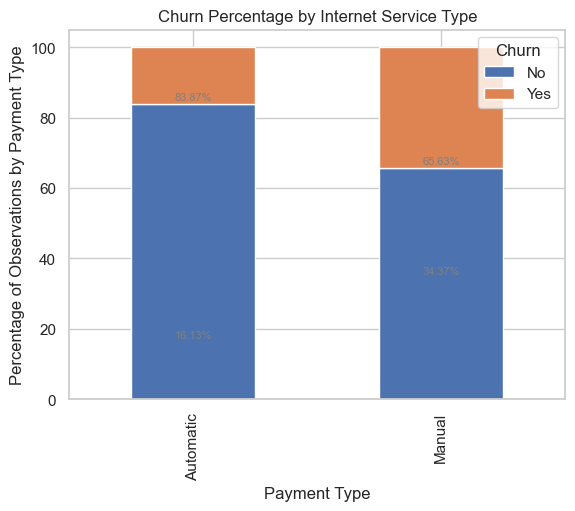

In [53]:
# Lets ask: Is whethere or not a customer churns independentt of if they have automatic or manual payments?

#### Vizually:
## Viz 1:
sns.set(style="whitegrid")
data = train
sns.countplot(x="mapped_payment_type", hue="churn", data=data)
plt.title("Churn Count by Payment_type Type")
plt.show()

## Viz 2:
# Calculate the percentages within each internet_service_type category
percentage_data = data.groupby('mapped_payment_type')['churn'].value_counts(normalize=True).unstack() * 100

# Set the style
sns.set(style="whitegrid")

# Create the bar plot
ax = percentage_data.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel("Payment Type")
plt.ylabel("Percentage of Observations by Payment Type")
plt.title("Churn Percentage by Internet Service Type")

# Annotate with percentage values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='gray', rotation=0, xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.legend(title='Churn', loc='upper right')
plt.show()

In [54]:
### It looks like customers with manual payments churn more often than those with automatic.

In [55]:
### Stats testing
## Categorical to Categorical
## Enough samples to assume normal distribution
# Let use a chi2 test

In [56]:
# H0: Customer churn rate is independent of the payment type.
# Ha: Customer churn rate has a dependent relationship to payment type.
alpha = 0.05

observed = pd.crosstab(train['internet_service_type'], train['churn'])
observed

churn,No,Yes
internet_service_type,,
DSL,1191,277
Fiber optic,1070,776
No Internet Service,843,68


In [57]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [58]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')

Observed Values

[[1191  277]
 [1070  776]
 [ 843   68]]
---
Expected Values

[[1078  389]
 [1356  489]
 [ 669  241]]
---

chi^2 = 441.8018
p     = 0.0000


In [59]:
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between payment type and churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between payment type and churn.')

p-value: 1.1586538084825805e-96
We reject the null hypothesis.
There exists some relationship between payment type and churn.


In [60]:
train.tech_support

6250                    Yes
3458                     No
5970                     No
5861    No internet service
343     No internet service
               ...         
4405                    Yes
5907    No internet service
552                     Yes
3226    No internet service
6665                     No
Name: tech_support, Length: 4225, dtype: object

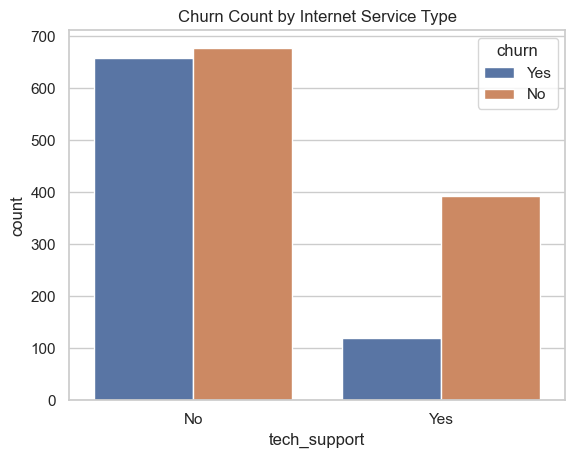

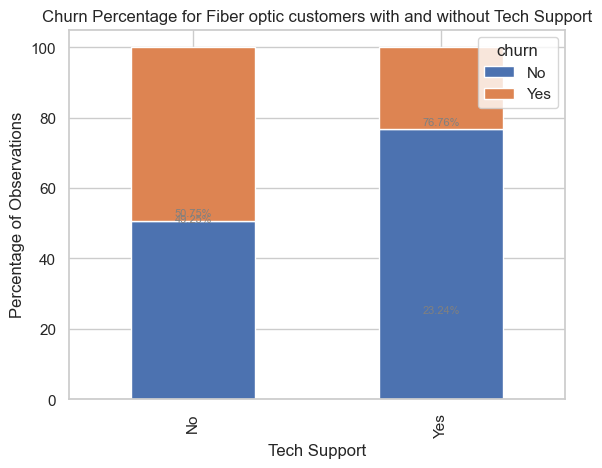

In [61]:
# Lets ask: For fiber optic customers does the addition of tech support change churn rate?
# Visually:
# Fiber subset
fiber_subset = train[train['internet_service_type'] == 'Fiber optic']

sns.set(style="whitegrid")
sns.countplot(x="tech_support", hue="churn", data=fiber_subset)
plt.title("Churn Count by Internet Service Type")
plt.show()

## Viz 2:
# Calculate the percentages within each internet_service_type category
percentage_data = fiber_subset.groupby('tech_support')['churn'].value_counts(normalize=True).unstack() * 100

# Set the style
sns.set(style="whitegrid")

# Create the bar plot
ax = percentage_data.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel("Tech Support")
plt.ylabel("Percentage of Observations")
plt.title("Churn Percentage for Fiber optic customers with and without Tech Support")

# Annotate with percentage values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='gray', rotation=0, xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.legend(title='churn', loc='upper right')
plt.show()

In [62]:
# Lets ask: Is whether or not a fiber optic customer churns independent of if they have tech support?
#H0: Fiber optic customer churn is independent on tech support.
#Ha: Fiber optic customer churn is dependent on tech support.
alpha = 0.05

In [63]:
observed = pd.crosstab(fiber_subset.churn, fiber_subset.tech_support)
observed

tech_support,No,Yes
churn,,
No,677,393
Yes,657,119


In [64]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [65]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[677 393]
 [657 119]]
---
Expected Values

[[773 296]
 [560 215]]
---

chi^2 = 101.6500
p     = 0.0000


In [66]:
if p < alpha:
    print(f'p-value: {p}')
    print(f'We reject the null hypothesis.')
    print(f'There exists some relationship between tech support and the churn.')
else:
    print(f'p-value: {p}')
    print(f'We fail to reject the null hypothesis.')
    print(f'There is not a significant relationship between tech support and churn.')

p-value: 6.625286470594788e-24
We reject the null hypothesis.
There exists some relationship between tech support and the churn.


## Model
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver

In [99]:
baseline_accuracy = (train.churn == 'No').mean()
print(f'Baseline accuracy is{baseline_accuracy: .2%}')

Baseline accuracy is 73.47%


In [68]:
train.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'internet_service_type', 'mapped_payment_type',
       'gender_encoded', 'partner_encoded', 'dependents_encoded',
       'phone_service_encoded', 'paperless_billing_encoded', 'churn_encoded',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'contrac

In [69]:
# Drop unencoded columns for training dataframe
#training_columns = ['monthly_charges', 'internet_service_type_Fiber optic', 'internet_service_type_No Internet Service','mapped_payment_type_Manual', 'tech_support_Yes', 'phone_service_encoded', 'multiple_lines_Yes' ]

training_columns = ['monthly_charges', 'gender_encoded', 'partner_encoded', 'dependents_encoded',
       'phone_service_encoded', 'paperless_billing_encoded',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'contract_type_One year', 'contract_type_Two year',
       'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'mapped_payment_type_Manual']


In [70]:
# Drop unencoded columns for training dataframe
#training_columns = ['monthly_charges', 'internet_service_type_Fiber optic', 'internet_service_type_No Internet Service','mapped_payment_type_Manual', 'tech_support_Yes', 'phone_service_encoded', 'multiple_lines_Yes' ]

features1 = ['monthly_charges',
       'tech_support_No internet service', 'tech_support_Yes',
       'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'mapped_payment_type_Manual']

In [125]:
# INSTANTIATE OBJECT
clf = DecisionTreeClassifier(max_depth=5, random_state=666)
clf

DecisionTreeClassifier(max_depth=5, random_state=666)

In [126]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)

In [127]:
model_1_preds = clf.predict(X_train)

In [128]:
accuracy_score(y_train, model_1_preds)

0.7685207100591716

In [129]:
model_1_val_preds = clf.predict(X_val)

In [130]:
accuracy_score(# reals:
    y_val,
    # preds:
    model_1_val_preds)

0.7565649396735273

In [131]:
#for many
for x in range(1,20):
#     print(x)
    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(X_train, y_train)
    acc = clf.score(X_train, y_train)
    print(f'for depth of {x:2}, the accuracy is {round(acc,2)}')

for depth of  1, the accuracy is 0.73
for depth of  2, the accuracy is 0.75
for depth of  3, the accuracy is 0.76
for depth of  4, the accuracy is 0.76
for depth of  5, the accuracy is 0.77
for depth of  6, the accuracy is 0.78
for depth of  7, the accuracy is 0.79
for depth of  8, the accuracy is 0.79
for depth of  9, the accuracy is 0.8
for depth of 10, the accuracy is 0.81
for depth of 11, the accuracy is 0.82
for depth of 12, the accuracy is 0.83
for depth of 13, the accuracy is 0.84
for depth of 14, the accuracy is 0.85
for depth of 15, the accuracy is 0.86
for depth of 16, the accuracy is 0.87
for depth of 17, the accuracy is 0.87
for depth of 18, the accuracy is 0.88
for depth of 19, the accuracy is 0.88


In [132]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(X_train, y_train)
    
    # evaluate on train
    train_acc = clf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = clf.score(X_val, y_val)
    
    scores_all.append([x, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head()

,max_depth,train_acc,val_acc
2,3,0.763787,0.756565
4,5,0.768521,0.756565
8,9,0.801420,0.750887
10,11,0.818225,0.748048
3,4,0.764970,0.747339


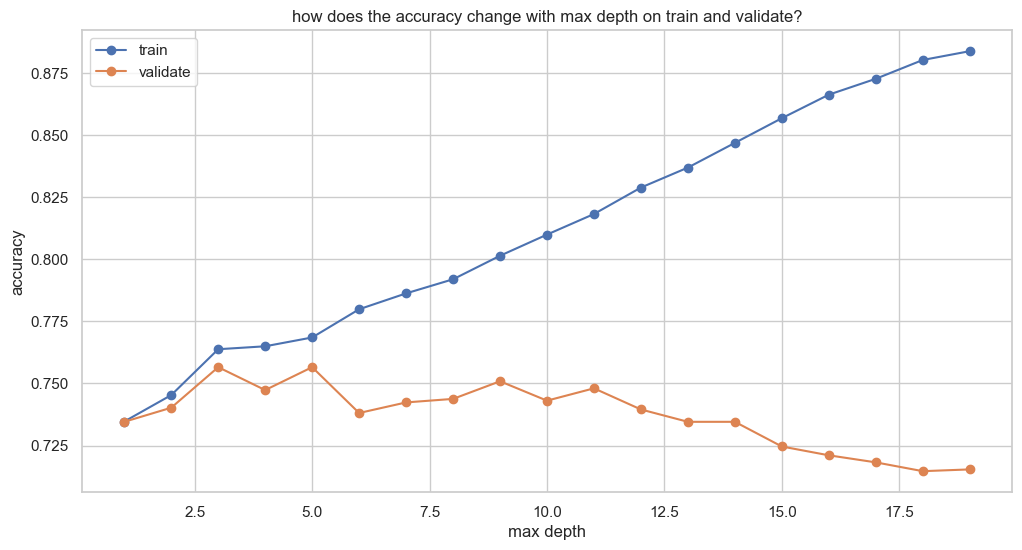

In [133]:
plt.figure(figsize=(12,6))
plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
plt.plot(scores_df.max_depth, scores_df.val_acc, label='validate', marker='o')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('how does the accuracy change with max depth on train and validate?')
plt.legend()
plt.show()

## Decision Tree:
- **Best model is one with a max depth of 5.**

## KNN:


In [134]:
X_train.columns

Index(['monthly_charges', 'tech_support_No internet service',
       'tech_support_Yes', 'internet_service_type_Fiber optic',
       'internet_service_type_No Internet Service',
       'mapped_payment_type_Manual'],
      dtype='object')

In [135]:
knn1 = KNeighborsClassifier()
knn1

KNeighborsClassifier()

In [136]:
knn1.fit(X_train, y_train)

KNeighborsClassifier()

In [137]:
y_pred = knn1.predict(X_train)
y_pred[:5]

array(['No', 'No', 'Yes', 'No', 'No'], dtype=object)

In [138]:
y_train[:5]

6250     No
3458     No
5970    Yes
5861     No
343      No
Name: churn, dtype: object

In [139]:
y_pred_proba = knn1.predict_proba(X_train)
y_pred_proba[:5]

array([[1. , 0. ],
       [1. , 0. ],
       [0.4, 0.6],
       [1. , 0. ],
       [0.8, 0.2]])

In [140]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn1.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.81


In [141]:
print(confusion_matrix(y_train, y_pred))

[[2857  247]
 [ 535  586]]


In [142]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.92      0.88      3104
         Yes       0.70      0.52      0.60      1121

    accuracy                           0.81      4225
   macro avg       0.77      0.72      0.74      4225
weighted avg       0.81      0.81      0.81      4225



In [143]:
cm = confusion_matrix(y_train, y_pred)

In [144]:
pred_dict = {
    'model': [],
    'accuracy': [],
    'true_positive_rate': [],
    'false_positive_rate': [],
    'true_negative_rate': [],
    'false_negative_rate': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'support_0': [],
    'support_1': []
}

for n in [5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train, y_train)
    
    y_preds = knn.predict(X_train)
    
    TN, FP, FN, TP = confusion_matrix(y_train, y_preds).ravel()
    ALL = TP + TN + FP + FN
    
    accuracy = (TP + TN)/ALL
    true_positive_rate = TP/(TP+FN)
    false_positive_rate = FP/(FP+TN)
    true_negative_rate = TN/(TN+FP)
    false_negative_rate = FN/(FN+TP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*(precision*recall)/(precision+recall)
    support_pos = TP + FN
    support_neg = FP + TN
    
    pred_dict['model'].append(f'knn_n_{n}')
    pred_dict['accuracy'].append(accuracy)
    pred_dict['true_positive_rate'].append(true_positive_rate)
    pred_dict['false_positive_rate'].append(false_positive_rate)
    pred_dict['true_negative_rate'].append(true_negative_rate)
    pred_dict['false_negative_rate'].append(false_negative_rate)
    pred_dict['precision'].append(precision)
    pred_dict['recall'].append(recall)
    pred_dict['f1_score'].append(f1_score)
    pred_dict['support_0'].append(support_pos)
    pred_dict['support_1'].append(support_neg)

In [145]:
pd.DataFrame(pred_dict).T

,0,1,2
model,knn_n_5,knn_n_10,knn_n_20
accuracy,0.814911,0.788639,0.781538
true_positive_rate,0.522748,0.384478,0.405888
false_positive_rate,0.079575,0.065399,0.082796
true_negative_rate,0.920425,0.934601,0.917204
false_negative_rate,0.477252,0.615522,0.594112
precision,0.703481,0.679811,0.639045
recall,0.522748,0.384478,0.405888
f1_score,0.599795,0.491168,0.496454
support_0,1121,1121,1121


In [146]:
pred_dict = {
    'model': [],
    'accuracy': [],
    'true_positive_rate': [],
    'false_positive_rate': [],
    'true_negative_rate': [],
    'false_negative_rate': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'support_0': [],
    'support_1': []
}

for n in [5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train, y_train)
    
    y_preds = knn.predict(X_val)
    
    TN, FP, FN, TP = confusion_matrix(y_val, y_preds).ravel()
    ALL = TP + TN + FP + FN
    
    accuracy = (TP + TN)/ALL
    true_positive_rate = TP/(TP+FN)
    false_positive_rate = FP/(FP+TN)
    true_negative_rate = TN/(TN+FP)
    false_negative_rate = FN/(FN+TP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*(precision*recall)/(precision+recall)
    support_pos = TP + FN
    support_neg = FP + TN
    
    pred_dict['model'].append(f'knn_n_{n}')
    pred_dict['accuracy'].append(accuracy)
    pred_dict['true_positive_rate'].append(true_positive_rate)
    pred_dict['false_positive_rate'].append(false_positive_rate)
    pred_dict['true_negative_rate'].append(true_negative_rate)
    pred_dict['false_negative_rate'].append(false_negative_rate)
    pred_dict['precision'].append(precision)
    pred_dict['recall'].append(recall)
    pred_dict['f1_score'].append(f1_score)
    pred_dict['support_0'].append(support_pos)
    pred_dict['support_1'].append(support_neg)

In [147]:
val_pred_df = pd.DataFrame(pred_dict).T
val_pred_df.columns = val_pred_df.iloc[0]
val_pred_df = val_pred_df.drop(val_pred_df.index[0])
val_pred_df

model,knn_n_5,knn_n_10,knn_n_20
accuracy,0.739532,0.74379,0.748758
true_positive_rate,0.390374,0.275401,0.31016
false_positive_rate,0.1343,0.086957,0.092754
true_negative_rate,0.8657,0.913043,0.907246
false_negative_rate,0.609626,0.724599,0.68984
precision,0.512281,0.533679,0.54717
recall,0.390374,0.275401,0.31016
f1_score,0.443096,0.363316,0.395904
support_0,374,374,374
support_1,1035,1035,1035


## Logistic Regression:

In [151]:
logit = LogisticRegression()

In [152]:
logit.fit(X_train, y_train)

LogisticRegression()

In [153]:
logit.score(X_train, y_train)

0.7623668639053255